Enter start month (YYYY-MM) or press enter to use default (2023-10):  
Enter end month (YYYY-MM) or press enter to use default (2024-02):  


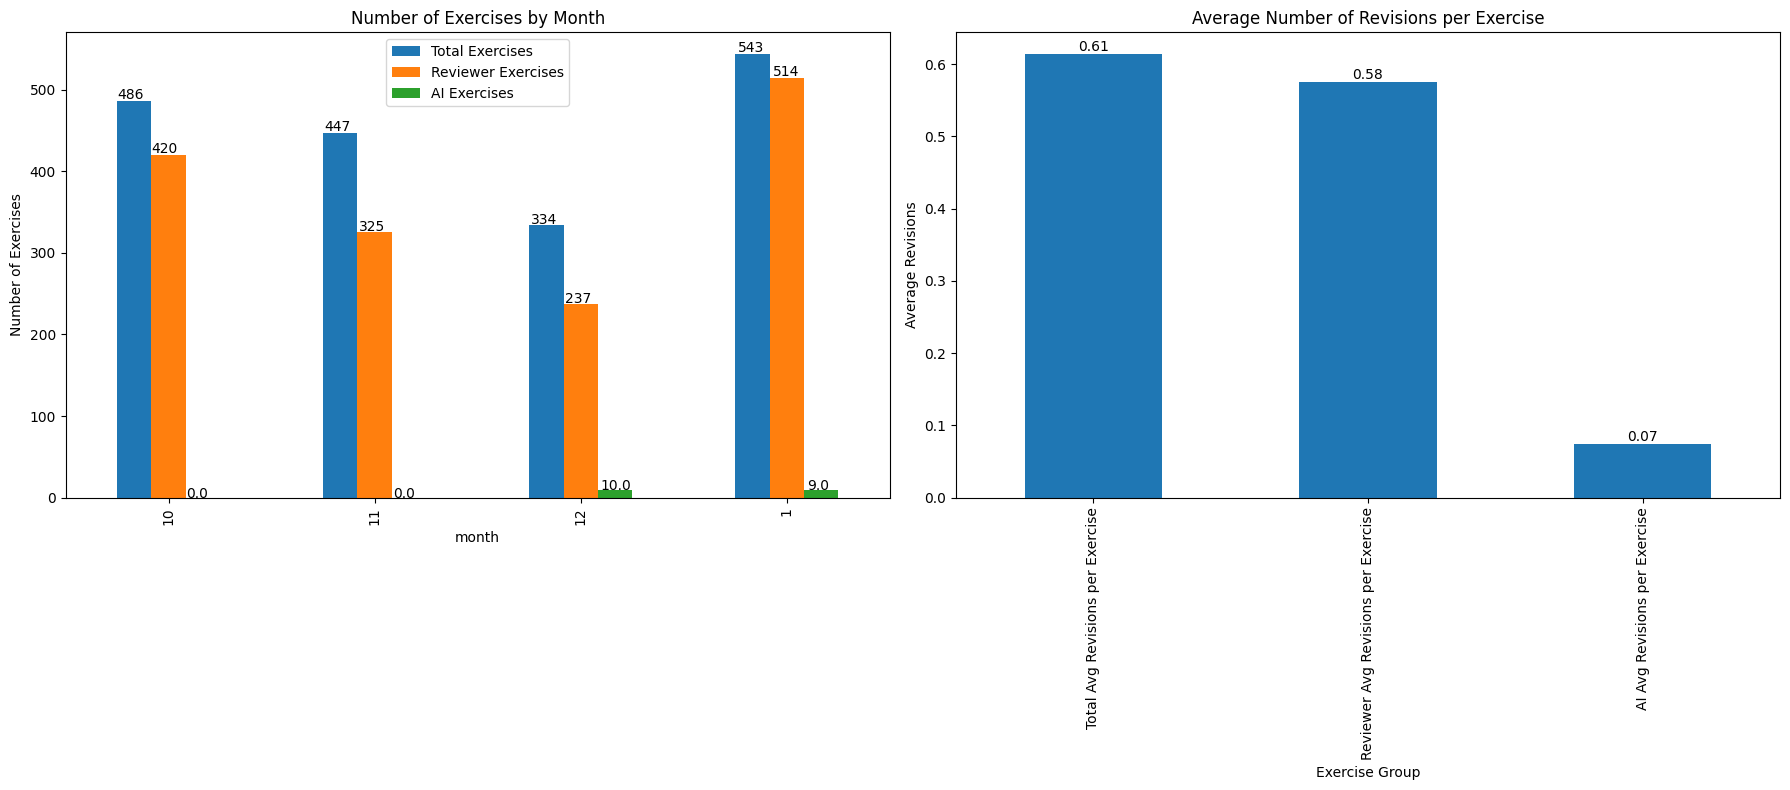

In [ ]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta



from IPython.display import display, Markdown, HTML

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def cached(func):
    cache = dict()

    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result

    return return_func

def query(sql, parameters):
    c = db.cursor()
    c.execute(sql, parameters)

    return c.fetchall()

def rename_columns(df, prefix):
    new_column_names = {
        'number_of_exercises': f'{prefix} Exercises',
        'number_of_revisions': f'{prefix} Revisions'
    }
    return df.rename(columns=new_column_names)

def sort_months(months):
    if 12 in months and 1 in months:
        # Find the first occurrence of a month after 12
        rollover_index = min(months.index(1), months.index(12)) + 1
        # Sort the months so that 12-01-02...
        return months[rollover_index:] + months[:rollover_index]
    else:
        return months



def fetch_exercises_by_month(start_month, end_month):
    start_month_formatted = pd.to_datetime(start_month).strftime("%Y-%m-%d")
    end_month_formatted = pd.to_datetime(end_month).strftime("%Y-%m-%d")
    # Entity type 1, 4, 5 are all the possible exercise types that can be
    # created.
    query_string = """
       SELECT
            MONTH(er.date) AS month,
            COUNT(DISTINCT e.id) AS exercise_count,
            COUNT(DISTINCT er.id) - COUNT(DISTINCT e.id) AS revision_count
        FROM
            entity_revision er
        JOIN entity e ON e.id = er.repository_id
        WHERE
            e.type_id IN (1, 4, 5)
            AND e.date >= %s
            AND e.date <= %s
            AND er.date >= %s
            AND er.date <= %s
        GROUP BY MONTH(er.date)
    """
    exercises_by_month = query(query_string, [start_month_formatted, end_month_formatted, start_month_formatted, end_month_formatted])

    exercise_counts = []

    for month, exercise_count, revision_count in exercises_by_month:
        exercise_counts.append({
            "month": month,
            "number_of_exercises": exercise_count,
            "number_of_revisions": revision_count
        })

    return exercise_counts

def fetch_exercises_by_month_with_role(start_month, end_month):
    start_month_formatted = pd.to_datetime(start_month).strftime("%Y-%m-%d")
    end_month_formatted = pd.to_datetime(end_month).strftime("%Y-%m-%d")
    # Hard coded role_id of 55 == 'de_reviewer' role
    query_string = """
        SELECT
            MONTH(er.date) AS month,
            COUNT(DISTINCT e.id) AS exercise_count,
            COUNT(DISTINCT er.id) - COUNT(DISTINCT e.id) AS revision_count
        FROM
            entity_revision er
        INNER JOIN user u ON u.id = er.author_id
        INNER JOIN role_user ru ON ru.user_id = u.id
        INNER JOIN entity e ON e.id = er.repository_id
        WHERE
            ru.role_id = 55
            AND e.type_id IN (1, 4, 5)
            AND e.date >= %s
            AND e.date <= %s
            AND er.date >= %s
            AND er.date <= %s
        GROUP BY
            MONTH(er.date)
    """
    exercises_by_month = query(query_string, [start_month_formatted, end_month_formatted, start_month_formatted, end_month_formatted])

    exercise_counts = []

    for month, exercise_count, revision_count in exercises_by_month:
        exercise_counts.append({
            "month": month,
            "number_of_exercises": exercise_count,
            "number_of_revisions": revision_count
        })

    return exercise_counts


def fetch_ai_exercises_by_month(start_month, end_month):
    start_month_formatted = pd.to_datetime(start_month).strftime("%Y-%m-%d")
    end_month_formatted = pd.to_datetime(end_month).strftime("%Y-%m-%d")
    # Note that it specifically shows the number of edits that were needed after
    # the AI generated the exercise. It does not list any revisions of exercises
    # that were not created with AI.
    query_string = """
        WITH AI_Created_Exercises AS (
            SELECT DISTINCT e.id
            FROM entity_revision er
            JOIN entity_revision_field erf ON erf.entity_revision_id = er.id
            JOIN entity e ON e.id = er.repository_id
            WHERE erf.field LIKE 'changes' AND erf.value LIKE '[KI generiert%'
                  AND e.type_id IN (1, 4, 5)
                  AND e.date >= %s
                  AND e.date <= %s
        )
        SELECT
            MONTH(er.date) AS month,
            COUNT(DISTINCT e.id) AS exercise_count,
            COUNT(DISTINCT er.id) - COUNT(DISTINCT e.id) AS revision_count
        FROM entity_revision er
        JOIN entity e ON e.id = er.repository_id
        WHERE e.id IN (SELECT id FROM AI_Created_Exercises)
              AND e.type_id IN (1, 4, 5)
              AND er.date >= %s
              AND er.date <= %s
        GROUP BY MONTH(er.date)
    """
    exercises_by_month = query(query_string, [start_month_formatted, end_month_formatted, start_month_formatted, end_month_formatted])

    exercise_counts = []

    for month, exercise_count, revision_count in exercises_by_month:
        exercise_counts.append({
            "month": month,
            "number_of_exercises": exercise_count,
            "number_of_revisions": revision_count
        })

    return exercise_counts

if __name__ == "__main__":
    current_date = datetime.today()
    start_month = (current_date - relativedelta(months=3)).replace(day=1)
    end_month = (current_date + relativedelta(months=1)).replace(day=1)

    start_month_formatted = start_month.strftime("%Y-%m")
    end_month_formatted = end_month.strftime("%Y-%m")

    user_start_month = input(f"Enter start month (YYYY-MM) or press enter to use default ({start_month_formatted}): ")
    user_end_month = input(f"Enter end month (YYYY-MM) or press enter to use default ({end_month_formatted}): ")

    start_month_formatted = user_start_month or start_month_formatted
    end_month_formatted = user_end_month or end_month_formatted

    # only for debugging!
    # print("All exercises")
    # exercises = fetch_exercises_by_month(start_month, end_month)
    # df = pd.DataFrame(exercises)
    # display(df)


    # print("Exercises from 'german_reviewer' role")
    # exercises_with_role = fetch_exercises_by_month_with_role(start_month, end_month)
    # df_with_role = pd.DataFrame(exercises_with_role)
    # display(df_with_role)

    # print("Exercises generated by AI")
    # ai_exercises = fetch_ai_exercises_by_month(start_month, end_month)
    # df_ai_generated_exercises = pd.DataFrame(ai_exercises)
    # display(df_ai_generated_exercises)

    all_exercises = fetch_exercises_by_month(start_month_formatted, end_month_formatted)
    exercises_with_role = fetch_exercises_by_month_with_role(start_month_formatted, end_month_formatted)
    ai_exercises = fetch_ai_exercises_by_month(start_month_formatted, end_month_formatted)

    if all_exercises and 'month' in all_exercises[0]:
        df_all_exercises = pd.DataFrame(all_exercises).set_index('month')
        df_all_exercises = rename_columns(df_all_exercises, 'Total')
        df_all_exercises['Avg Revisions per Exercise'] = df_all_exercises['Total Revisions'] / df_all_exercises['Total Exercises']
    else:
        print("No data available for all exercises.")
        sys.exit()

    if exercises_with_role and 'month' in exercises_with_role[0]:
        df_exercises_with_role = pd.DataFrame(exercises_with_role).set_index('month')
        df_exercises_with_role = rename_columns(df_exercises_with_role, 'Reviewer')
        df_exercises_with_role['Avg Revisions per Reviewer Exercise'] = df_exercises_with_role['Reviewer Revisions'] / df_exercises_with_role['Reviewer Exercises']

    else:
        print("No data available for exercises created by Reviewers.")
        sys.exit()

    if ai_exercises and 'month' in ai_exercises[0]:
        df_ai_exercises = pd.DataFrame(ai_exercises).set_index('month')
        df_ai_exercises = rename_columns(df_ai_exercises, 'AI')
        df_ai_exercises['Avg Revisions per AI Exercise'] = df_ai_exercises['AI Revisions'] / df_ai_exercises['AI Exercises']
    else:
        print("No data available for AI exercises.")
        sys.exit()

    df_merged = pd.concat([df_all_exercises, df_exercises_with_role, df_ai_exercises], axis=1).fillna(0)

    # Ensure 01 (January) shows up after December.
    months = df_merged.index.tolist()
    sorted_months = sort_months(months)
    df_merged = df_merged.reindex(sorted_months)

    plt.figure(figsize=(18, 8))

    # Bar chart
    ax1 = plt.subplot(1, 2, 1)
    df_merged[[col for col in df_merged.columns if 'Exercises' in col]].plot(kind='bar', ax=ax1)
    ax1.set_ylabel('Number of Exercises')
    ax1.set_title('Number of Exercises by Month')
    ax1.legend()
    # Annotating bars
    for p in ax1.patches:
        ax1.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))



    # Bar chart for average revisions per exercise
    ax2 = plt.subplot(1, 2, 2)
    avg_revision_data = df_merged[['Avg Revisions per Exercise', 'Avg Revisions per Reviewer Exercise', 'Avg Revisions per AI Exercise']].mean()
    avg_revision_data.plot(kind='bar', ax=ax2)
    ax2.set_title('Average Number of Revisions per Exercise')
    ax2.set_ylabel('Average Revisions')

    # Annotating bars
    for i, value in enumerate(avg_revision_data):
        ax2.text(i, value, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
